In [1]:
import argparse
import yaml
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# Read config

In [2]:
config_path = 'configs/celebA_Young_Classifier.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)
    
for k in config.keys():
    print(k, config[k])

image_dir ./data/CelebA/images/
image_label_dict ./data/CelebA/Young_binary_classification.txt
log_dir ./output/classifier
name CelebA-Young
num_channel 3
num_class 1
input_size 128
batch_size 32
epochs 5
ckpt_dir_continue 


In [3]:
output_dir = os.path.join(config['log_dir'], config['name'], 'classifier_output')
print('Output directory: {}'.format(output_dir))

Output directory: ./output/classifier/CelebA-Young/classifier_output


In [4]:
data_df = pd.read_csv(config['image_label_dict'])
categories = data_df.columns[1: ].to_list()
print('Categories: {}'.format(categories))

Categories: ['Young']


# Load saved output from classifier

In [5]:
# Read classifier output
train_or_test = 'train'
names = np.load(os.path.join(output_dir, 'name_' + train_or_test+ '.npy'))
prediction_y = np.load(os.path.join(output_dir, 'prediction_y_' + train_or_test + '.npy'))
true_y = np.load(os.path.join(output_dir, 'true_y_' + train_or_test + '.npy'))
train_or_test = 'test'
names_i = np.load(os.path.join(output_dir,'name_' + train_or_test + '.npy'))
prediction_y_i = np.load(os.path.join(output_dir, 'prediction_y_' + train_or_test+'.npy'))
true_y_i = np.load(os.path.join(output_dir, 'true_y_' + train_or_test + '.npy'))

print(names.shape, prediction_y.shape, true_y.shape)
print(names_i.shape, prediction_y_i.shape, true_y_i.shape)

(135741,) (135741, 1) (135741, 1)
(66858,) (66858, 1) (66858, 1)


In [6]:
true_y = np.reshape(true_y, [-1,len(categories)])
true_y_i = np.reshape(true_y_i, [-1,len(categories)])

# View results from classifier

In [7]:
for i in range(prediction_y.shape[1]):
    print(categories[i],i)
    if prediction_y.shape[1] == 2:
        j = 1
    else:
        j = i
    print("ROC-AUC train: ", roc_auc_score(true_y[:,i], prediction_y[:,j]))
    try:
        print("ROC-AUC test: ", roc_auc_score(true_y_i[:,i], prediction_y_i[:,j]))
    except:
        a = 0
    print("Accuracy train: ", accuracy_score(true_y[:,i], (prediction_y[:,j]>0.5).astype(int)))
    print("Accuracy test: ", accuracy_score(true_y_i[:,i], (prediction_y_i[:,j]>0.5).astype(int)))
    print("Recall train: ", recall_score(true_y[:,i], (prediction_y[:,j]>0.5).astype(int)))
    print("Recall test: ", recall_score(true_y_i[:,i], (prediction_y_i[:,j]>0.5).astype(int)))
    tp = np.sum((prediction_y[true_y[:,i] == 1,j]>0.5).astype(int))
    tp_i = np.sum((prediction_y_i[true_y_i[:,i] == 1,j]>0.5).astype(int))
    print("Stats train: ", np.unique(true_y[:,i], return_counts=True), tp)
    print("Stats test: ", np.unique(true_y_i[:,i], return_counts=True),tp_i)
    print(confusion_matrix(true_y_i[:,i],  (prediction_y_i[:,j]>0.5).astype(int)))
    print(confusion_matrix(true_y[:,i],  (prediction_y[:,j]>0.5).astype(int)))
    if prediction_y.shape[1] == 2:
        break

Young 0
ROC-AUC train:  0.9908654603670165
ROC-AUC test:  0.9369209913741678
Accuracy train:  0.9605646046515054
Accuracy test:  0.896601752968979
Recall train:  0.9814679021398574
Recall test:  0.9483635238850117
Stats train:  (array([0., 1.], dtype=float32), array([ 30734, 105007])) 103061
Stats test:  (array([0., 1.], dtype=float32), array([15131, 51727])) 49056
[[10889  4242]
 [ 2671 49056]]
[[ 27327   3407]
 [  1946 103061]]


# Choose a target class to build explanation

In [8]:
current_index = 0
name = categories[current_index]
print(name)
current_index_prob = 1

Young


# Create a dataframe from results

In [9]:
if len(categories) == 1:
    df_test_results = pd.DataFrame(data = [names_i, true_y_i[:, 0], prediction_y_i[:, 0]]).T
else:
    df_test_results = pd.DataFrame(data = [names_i, true_y_i[:,current_index], prediction_y_i[:,current_index_prob]]).T

df_test_results = df_test_results.rename(index=str, columns={0: "filename", 1: "label", 2:"prob"})
df_test_results['bin'] = np.floor(df_test_results["prob"].astype('float') * 10).astype('int')
print(df_test_results.shape)
print(np.unique(df_test_results['bin'] ,return_counts=True))
df_test_results.head(3)

(66858, 4)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 7932,  1780,  1365,  1232,  1251,  1368,  1712,  2364,  4202,
       43580,    72]))


,filename,label,prob,bin
0,./data/CelebA/images/050310.jpg,0,0.0017352,0
1,./data/CelebA/images/175279.jpg,1,0.999445,9
2,./data/CelebA/images/011029.jpg,1,0.999737,9


In [10]:
if len(categories) == 1:
    df_train_results = pd.DataFrame(data = [names, true_y[:, 0], prediction_y[:, 0]]).T
else:
    df_train_results = pd.DataFrame(data = [names, true_y[:,current_index], prediction_y[:,current_index_prob]]).T

df_train_results = df_train_results.rename(index=str, columns={0: "filename", 1: "label", 2:"prob"})
df_train_results['bin'] = np.floor(df_train_results["prob"].astype('float') * 10).astype('int')
print(df_train_results.shape)
print(np.unique(df_train_results['bin'] ,return_counts=True))
df_train_results.head(3)

(135741, 4)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([18639,  3979,  2559,  2128,  1968,  1993,  2465,  3613,  7205,
       91031,   161]))


,filename,label,prob,bin
0,./data/CelebA/images/065143.jpg,1,0.99753,9
1,./data/CelebA/images/025166.jpg,1,0.995238,9
2,./data/CelebA/images/155702.jpg,1,0.998878,9


In [11]:
df = pd.concat([df_train_results, df_test_results])
df = df.drop_duplicates()
print(df.shape)
df.head(1)

(202599, 4)


,filename,label,prob,bin
0,./data/CelebA/images/065143.jpg,1,0.99753,9


# Plot reliability curve

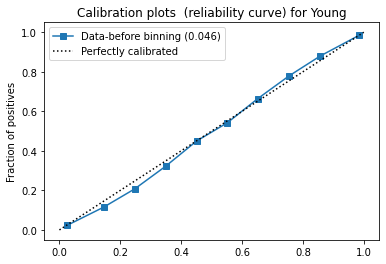

In [12]:
import matplotlib.pyplot as plt

#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df['label']).astype(int)
predicted_prob = np.asarray(df["prob"]).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-before binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
#plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+ name)
plt.legend()
plt.show()

# Create bins

In [13]:
df.head(1)

,filename,label,prob,bin
0,./data/CelebA/images/065143.jpg,1,0.99753,9


In [14]:
df.groupby(by='bin').count()

,filename,label,prob
bin,,,
0,26571,26571,26571
1,5759,5759,5759
2,3924,3924,3924
3,3360,3360,3360
4,3219,3219,3219
5,3361,3361,3361
6,4177,4177,4177
7,5977,5977,5977
8,11407,11407,11407


In [15]:
n = 5000

# Calibrated Sampling

In [17]:
for i in range(10):
    print(i)
    df_bin = df.loc[df['bin'] == i]
    print(df_bin.shape)
    print(np.min(df_bin['prob']), np.max(df_bin['prob']))
    print(np.unique(df_bin['label'],return_counts=True))
    df_bin_0 = df.loc[(df['bin'] == i) & (df['label'] ==0)]
    df_bin_1 = df.loc[(df['bin'] == i) & (df['label'] ==1)]
    n_0 = int((1 - (0.1 * i) ) * n)
    if df_bin_0.shape[0] >= n_0:
        df_bin = df_bin_0.sample(n=n_0)
    else:
        df_bin = df_bin_0
        n_0 = df_bin_0.shape[0]
    n_1 = n - n_0
    if df_bin_1.shape[0] >= n_1:
        df_bin = pd.concat([df_bin, df_bin_1.sample(n=n_1)])        
    else:
        df_bin = pd.concat([df_bin, df_bin_1])    
        
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin['label'],return_counts=True))

0
(26571, 4)
4.456471e-06 0.09998766
(array([0.0, 1.0], dtype=object), array([25961,   610]))
(5000, 4)
(array([0.0], dtype=object), array([5000]))
1
(5759, 4)
0.10000053 0.19999819
(array([0.0, 1.0], dtype=object), array([5096,  663]))
(10000, 4)
(array([0.0, 1.0], dtype=object), array([4500,  500]))
2
(3924, 4)
0.20001358 0.29996082
(array([0.0, 1.0], dtype=object), array([3108,  816]))
(13924, 4)
(array([0.0, 1.0], dtype=object), array([3108,  816]))
3
(3360, 4)
0.3000233 0.3999649
(array([0.0, 1.0], dtype=object), array([2279, 1081]))
(17284, 4)
(array([0.0, 1.0], dtype=object), array([2279, 1081]))
4
(3219, 4)
0.40001038 0.49999523
(array([0.0, 1.0], dtype=object), array([1772, 1447]))
(20503, 4)
(array([0.0, 1.0], dtype=object), array([1772, 1447]))
5
(3361, 4)
0.500038 0.59997016
(array([0.0, 1.0], dtype=object), array([1540, 1821]))
(23864, 4)
(array([0.0, 1.0], dtype=object), array([1540, 1821]))
6
(4177, 4)
0.6000034 0.69995755
(array([0.0, 1.0], dtype=object), array([1402, 2

In [18]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5000, 5000, 3924, 3360, 3219, 3361, 4177, 5000, 5000, 5000]))


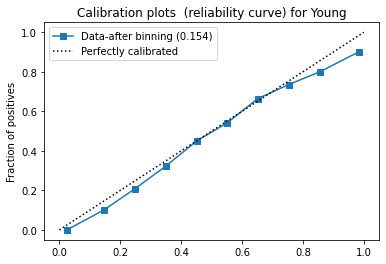

In [19]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all['label']).astype(int)
predicted_prob = np.asarray(df_bin_all['prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

# Save the output

In [22]:
experiment_dir = os.path.join('.'+config['log_dir'], config['name'], 'explainer_input')

In [37]:
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

../output/classifier/CelebA-Young/explainer_input Young


In [38]:
df_temp = df_bin_all[['filename', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), 'r+')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ', index = None)
df_test_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Test_'+name+'.csv'), sep = ' ', index = None)
df_train_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Train_'+name+'.csv'), sep = ' ', index = None)

(43041, 2)
43041

0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99

./data/CelebA/images/095386.jpg 9

./data/CelebA/images/153136.jpg 9

./data/CelebA/images/102465.jpg 9

./data/CelebA/images/125074.jpg 9



In [28]:
df_combine = pd.read_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ')

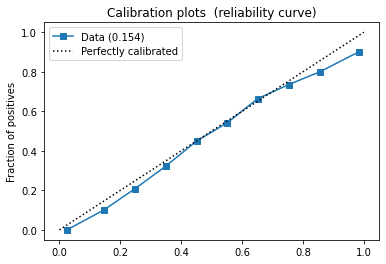

In [36]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

fraction_of_positives, mean_predicted_value = calibration_curve(df_combine['label'], df_combine["prob"], n_bins=10)
clf_score = brier_score_loss(df_combine['label'], df_combine["prob"], pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve)')
plt.legend()
plt.show()